# TensorFlow Convolutional Neural Network for Image Classification

In [7]:
import time
import math
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import dataset
import cv2

from sklearn.metrics import confusion_matrix
from datetime import timedelta

%matplotlib inline

## Configuration and Hyperparameters

In [8]:
# Convolutional Layer 1.
filter_size1 = 3 
num_filters1 = 32

# Convolutional Layer 2.
filter_size2 = 3
num_filters2 = 32

# Convolutional Layer 3.
filter_size3 = 3
num_filters3 = 64

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

# Number of color channels for the images: 1 channel for gray-scale.
num_channels = 3

# image dimensions (only squares for now)
img_size = 128

# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# class info
classes = ['dog', 'cat']
num_classes = len(classes)

# batch size
batch_size = 32

# validation split
validation_size = .16

# how long to wait after validation loss stops improving before terminating training
early_stopping = None  # use None if you don't want to implement early stoping

train_path = 'C:/Users/tanw/Desktop/Kaggle/DogsvsCats/traindogscats'
test_path = 'C:/Users/tanw/Desktop/Kaggle/DogsvsCats/testdogscats'
checkpoint_dir = "C:/Users/tanw/Desktop/Kaggle/DogsvsCats/.ipynb_checkpoints"

## Load Data

In [9]:
data = dataset.read_train_sets(train_path, img_size, classes, validation_size=validation_size)
test_images, test_ids = dataset.read_test_set(test_path, img_size)

Reading training images
Loading dog files (Index: 0)
Loading cat files (Index: 1)
Reading test images


In [10]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(test_images)))
print("- Validation-set:\t{}".format(len(data.valid.labels)))

Size of:
- Training-set:		21000
- Test-set:		12500
- Validation-set:	4000


### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid (or fewer, depending on how many images are passed), and writing the true and predicted classes below each image.

In [11]:
def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
        
    images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_size, img_size, num_channels))

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

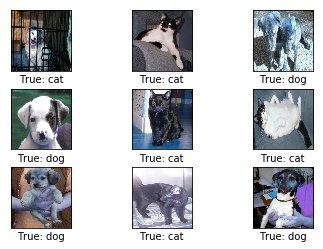

In [14]:
# Get some random images and their labels from the train set.

images, cls_true  = data.train.images, data.train.cls

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## TensorFlow Graph

The entire purpose of TensorFlow is to have a so-called computational graph that can be executed much more efficiently than if the same calculations were to be performed directly in Python. TensorFlow can be more efficient than NumPy because TensorFlow knows the entire computation graph that must be executed, while NumPy only knows the computation of a single mathematical operation at a time.

TensorFlow can also automatically calculate the gradients that are needed to optimize the variables of the graph so as to make the model perform better. This is because the graph is a combination of simple mathematical expressions so the gradient of the entire graph can be calculated using the chain-rule for derivatives.

A TensorFlow graph consists of the following parts which will be detailed below:

* Placeholder variables used for inputting data to the graph.
* Variables that are going to be optimized so as to make the convolutional network perform better.
* The mathematical formulas for the convolutional network.
* A cost measure that can be used to guide the optimization of the variables.
* An optimization method which updates the variables.

### Helper-functions for creating new variables

Functions for creating new TensorFlow variables in the given shape and initializing them with random values. Note that the initialization is not actually done at this point, it is merely being defined in the TensorFlow graph.

In [15]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [16]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

### Helper-function for creating a new Convolutional Layer

This function creates a new convolutional layer in the computational graph for TensorFlow. Nothing is actually calculated here, we are just adding the mathematical formulas to the TensorFlow graph.

It is assumed that the input is a 4-dim tensor with the following dimensions:

1. Image number.
2. Y-axis of each image.
3. X-axis of each image.
4. Channels of each image.

Note that the input channels may either be colour-channels, or it may be filter-channels if the input is produced from a previous convolutional layer.

The output is another 4-dim tensor with the following dimensions:

1. Image number, same as input.
2. Y-axis of each image. If 2x2 pooling is used, then the height and width of the input images is divided by 2.
3. X-axis of each image. Ditto.
4. Channels produced by the convolutional filters.

In [17]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

### Helper-function for flattening a layer

A convolutional layer produces an output tensor with 4 dimensions. We will add fully-connected layers after the convolution layers, so we need to reduce the 4-dim tensor to 2-dim which can be used as input to the fully-connected layer.

In [18]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

### Helper-function for creating a new Fully-Connected Layer

This function creates a new fully-connected layer in the computational graph for TensorFlow. Nothing is actually calculated here, we are just adding the mathematical formulas to the TensorFlow graph.

It is assumed that the input is a 2-dim tensor of shape `[num_images, num_inputs]`. The output is a 2-dim tensor of shape `[num_images, num_outputs]`.

In [19]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

### Placeholder variables

Placeholder variables serve as the input to the TensorFlow computational graph that we may change each time we execute the graph. We call this feeding the placeholder variables and it is demonstrated further below.

First we define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional vector or matrix. The data-type is set to `float32` and the shape is set to `[None, img_size_flat]`, where `None` means that the tensor may hold an arbitrary number of images with each image being a vector of length `img_size_flat`.

In [20]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

The convolutional layers expect `x` to be encoded as a 4-dim tensor so we have to reshape it so its shape is instead `[num_images, img_height, img_width, num_channels]`. Note that `img_height == img_width == img_size` and `num_images` can be inferred automatically by using -1 for the size of the first dimension. So the reshape operation is:

In [21]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable `x`. The shape of this placeholder variable is `[None, num_classes]` which means it may hold an arbitrary number of labels and each label is a vector of length `num_classes`.

In [22]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

We could also have a placeholder variable for the class-number, but we will instead calculate it using argmax. Note that this is a TensorFlow operator so nothing is calculated at this point.

In [26]:
y_true_cls = tf.argmax(y_true, axis=1)

### Convolutional Layer 1

Create the first convolutional layer. It takes `x_image` as input and creates `num_filters1` different filters, each having width and height equal to `filter_size1`. Finally we wish to down-sample the image so it is half the size by using 2x2 max-pooling.

In [27]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

In [28]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 64, 64, 32) dtype=float32>

### Convolutional Layers 2 and 3

Create the second and third convolutional layers, which take as input the output from the first and second convolutional layer respectively. The number of input channels corresponds to the number of filters in the previous convolutional layer.

In [29]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

In [30]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 32, 32, 32) dtype=float32>

In [31]:
layer_conv3, weights_conv3 = \
    new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True)

In [32]:
layer_conv3

<tf.Tensor 'Relu_2:0' shape=(?, 16, 16, 64) dtype=float32>

### Flatten Layer

The convolutional layers output 4-dim tensors. We now wish to use these as input in a fully-connected network, which requires for the tensors to be reshaped or flattened to 2-dim tensors.

In [33]:
layer_flat, num_features = flatten_layer(layer_conv3)

In [34]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 16384) dtype=float32>

In [35]:
num_features

16384

### Fully-Connected Layer 1

Add a fully-connected layer to the network. The input is the flattened layer from the previous convolution. The number of neurons or nodes in the fully-connected layer is `fc_size`. ReLU is used so we can learn non-linear relations.

In [36]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

Check that the output of the fully-connected layer is a tensor with shape (?, 128) where the ? means there is an arbitrary number of images and `fc_size` == 128.

In [37]:
layer_fc1

<tf.Tensor 'Relu_3:0' shape=(?, 128) dtype=float32>

### Fully-Connected Layer 2

Add another fully-connected layer that outputs vectors of length num_classes for determining which of the classes the input image belongs to. Note that ReLU is not used in this layer.

In [38]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [39]:
layer_fc2

<tf.Tensor 'add_4:0' shape=(?, 2) dtype=float32>

### Predicted Class

The second fully-connected layer estimates how likely it is that the input image belongs to each of the 2 classes. However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each element is limited between zero and one and the all the elements sum to one. This is calculated using the so-called softmax function and the result is stored in `y_pred`.

In [40]:
y_pred = tf.nn.softmax(layer_fc2)

The class-number is the index of the largest element.

In [42]:
y_pred_cls = tf.argmax(y_pred, axis=1)

### Cost-function to be optimized

To make the model better at classifying the input images, we must somehow change the variables for all the network layers. To do this we first need to know how well the model currently performs by comparing the predicted output of the model `y_pred` to the desired output `y_true`.

The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the variables of the network layers.

TensorFlow has a built-in function for calculating the cross-entropy. Note that the function calculates the softmax internally so we must use the output of `layer_fc2` directly rather than `y_pred` which has already had the softmax applied.

In [43]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

We have now calculated the cross-entropy for each of the image classifications so we have a measure of how well the model performs on each image individually. But in order to use the cross-entropy to guide the optimization of the model's variables we need a single scalar value, so we simply take the average of the cross-entropy for all the image classifications.

In [44]:
cost = tf.reduce_mean(cross_entropy)

### Optimization Method

Now that we have a cost measure that must be minimized, we can then create an optimizer. In this case it is the `AdamOptimizer` which is an advanced form of Gradient Descent.

Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.

In [45]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

### Performance Measures

We need a few more performance measures to display the progress to the user.

This is a vector of booleans whether the predicted class equals the true class of each image.

In [46]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

This calculates the classification accuracy by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then calculating the average of these numbers.

In [47]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

### Create TensorFlow session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [48]:
session = tf.Session()

### Initialize variables

The variables for `weights` and `biases` must be initialized before we start optimizing them.

In [50]:
session.run(tf.global_variables_initializer())

### Helper-function to perform optimization iterations

It takes a long time to calculate the gradient of the model using the entirety of a large dataset
. We therefore only use a small batch of images in each iteration of the optimizer.

If your computer crashes or becomes very slow because you run out of RAM, then you may try and lower this number, but you may then need to perform more optimization iterations.

In [51]:
train_batch_size = batch_size

In [52]:
def print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss):
    # Calculate the accuracy on the training-set.
    acc = session.run(accuracy, feed_dict=feed_dict_train)
    val_acc = session.run(accuracy, feed_dict=feed_dict_validate)
    msg = "Epoch {0} --- Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%}, Validation Loss: {3:.3f}"
    print(msg.format(epoch + 1, acc, val_acc, val_loss))

Function for performing a number of optimization iterations so as to gradually improve the variables of the network layers. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples.  The progress is printed every 100 iterations.

In [53]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    best_val_loss = float("inf")
    patience = 0

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch, _, cls_batch = data.train.next_batch(train_batch_size)
        x_valid_batch, y_valid_batch, _, valid_cls_batch = data.valid.next_batch(train_batch_size)

        # Convert shape from [num examples, rows, columns, depth]
        # to [num examples, flattened image shape]

        x_batch = x_batch.reshape(train_batch_size, img_size_flat)
        x_valid_batch = x_valid_batch.reshape(train_batch_size, img_size_flat)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        
        feed_dict_validate = {x: x_valid_batch,
                              y_true: y_valid_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)
        

        # Print status at end of each epoch (defined as full pass through training dataset).
        if i % int(data.train.num_examples/batch_size) == 0: 
            val_loss = session.run(cost, feed_dict=feed_dict_validate)
            epoch = int(i / int(data.train.num_examples/batch_size))
            
            print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss)
            
            if early_stopping:    
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience = 0
                else:
                    patience += 1

                if patience == early_stopping:
                    break

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))

### Helper-function to plot example errors

Function for plotting examples of images from the test-set that have been mis-classified.

In [54]:
def plot_example_errors(cls_pred, correct):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.valid.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.valid.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper-function to plot confusion matrix

In [55]:
def plot_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.valid.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for showing the performance

Function for printing the classification accuracy on the test-set.

It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.

Note that this function can use a lot of computer memory, which is why the test-set is split into smaller batches. If you have little RAM in your computer and it crashes, then you can try and lower the batch-size.

In [56]:
def print_validation_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.valid.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.valid.images[i:j, :].reshape(batch_size, img_size_flat)
        

        # Get the associated labels.
        labels = data.valid.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    cls_true = np.array(data.valid.cls)
    cls_pred = np.array([classes[x] for x in cls_pred]) 

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Performance after 1 optimization iteration

In [57]:
optimize(num_iterations=1)
print_validation_accuracy()

Epoch 1 --- Training Accuracy:  53.1%, Validation Accuracy:  12.5%, Validation Loss: 0.806
Time elapsed: 0:00:02
Accuracy on Test-Set: 49.6% (1984 / 4000)


## Performance after 100 optimization iterations

After 100 optimization iterations, the model should have significantly improved its classification accuracy.

In [58]:
optimize(num_iterations=99)  # We already performed 1 iteration above.

Time elapsed: 0:01:31


In [2]:
print_validation_accuracy(show_example_errors=True)

NameError: name 'print_validation_accuracy' is not defined

## Performance after 1000 optimization iterations

In [47]:
optimize(num_iterations=900)  # We performed 100 iterations above.

Epoch 2 --- Training Accuracy:  68.8%, Validation Accuracy:  62.5%, Validation Loss: 0.614
Time elapsed: 0:06:09


In [1]:
print_validation_accuracy(show_example_errors=True)

NameError: name 'print_validation_accuracy' is not defined

## Performance after 10,000 optimization iterations

In [49]:
optimize(num_iterations=9000) # We performed 1000 iterations above.

Epoch 3 --- Training Accuracy:  78.1%, Validation Accuracy:  68.8%, Validation Loss: 0.539
Epoch 4 --- Training Accuracy:  81.2%, Validation Accuracy:  84.4%, Validation Loss: 0.473
Epoch 5 --- Training Accuracy:  78.1%, Validation Accuracy:  75.0%, Validation Loss: 0.410
Epoch 6 --- Training Accuracy:  78.1%, Validation Accuracy:  78.1%, Validation Loss: 0.427
Epoch 7 --- Training Accuracy:  84.4%, Validation Accuracy:  81.2%, Validation Loss: 0.495
Epoch 8 --- Training Accuracy:  84.4%, Validation Accuracy:  81.2%, Validation Loss: 0.468
Epoch 9 --- Training Accuracy:  87.5%, Validation Accuracy:  81.2%, Validation Loss: 0.485
Epoch 10 --- Training Accuracy:  90.6%, Validation Accuracy:  78.1%, Validation Loss: 0.456
Epoch 11 --- Training Accuracy:  90.6%, Validation Accuracy:  78.1%, Validation Loss: 0.609
Epoch 12 --- Training Accuracy:  90.6%, Validation Accuracy:  81.2%, Validation Loss: 0.501
Epoch 13 --- Training Accuracy:  93.8%, Validation Accuracy:  84.4%, Validation Loss: 0

Accuracy on Test-Set: 79.4% (3177 / 4000)
Example errors:


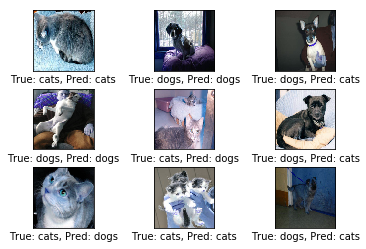

Confusion Matrix:
[[1673  351]
 [ 472 1504]]


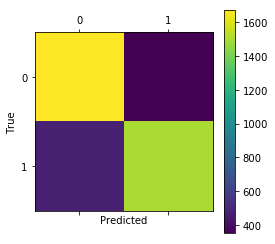

In [50]:
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

## Test on Sample Image

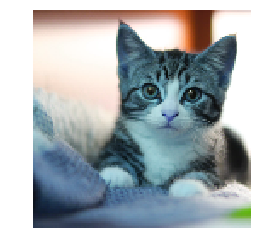

In [51]:
plt.axis('off')

test_cat = cv2.imread('cat.jpg')
test_cat = cv2.resize(test_cat, (img_size, img_size), cv2.INTER_LINEAR) / 255

preview_cat = plt.imshow(test_cat.reshape(img_size, img_size, num_channels))

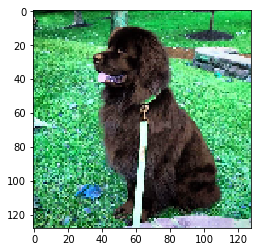

In [52]:
test_dog = cv2.imread('lucy.jpg')
test_dog = cv2.resize(test_dog, (img_size, img_size), cv2.INTER_LINEAR) / 255

preview_dog = plt.imshow(test_dog.reshape(img_size, img_size, num_channels))

In [53]:
def sample_prediction(test_im):
    
    feed_dict_test = {
        x: test_im.reshape(1, img_size_flat),
        y_true: np.array([[1, 0]])
    }

    test_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    return classes[test_pred[0]]

print("Predicted class for test_cat: {}".format(sample_prediction(test_cat)))
print("Predicted class for test_dog: {}".format(sample_prediction(test_dog)))

Predicted class for test_cat: cats
Predicted class for test_dog: dogs


## Visualization of Weights and Layers

In trying to understand why the convolutional neural network can recognize images, we will now visualize the weights of the convolutional filters and the resulting output images.

### Helper-function for plotting convolutional weights

In [54]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for plotting the output of a convolutional layer

In [55]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.
    
    image = image.reshape(img_size_flat)

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Input Images

Helper-function for plotting an image.

In [56]:
def plot_image(image):
    plt.imshow(image.reshape(img_size, img_size, num_channels),
               interpolation='nearest')
    plt.show()

Plot an image from the test-set which will be used as an example below.

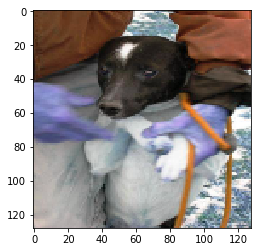

In [57]:
image1 = test_images[0]
plot_image(image1)

Plot another example image from the test-set.

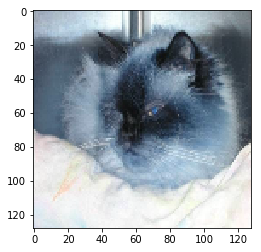

In [58]:
image2 = test_images[13]
plot_image(image2)

### Convolution Layer 1

Now plot the filter-weights for the first convolutional layer.

Note that positive weights are red and negative weights are blue.

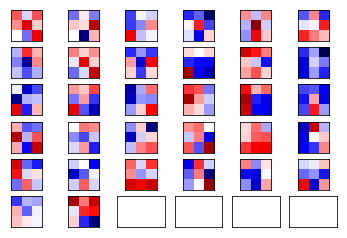

In [59]:
plot_conv_weights(weights=weights_conv1)

Applying each of these convolutional filters to the first input image gives the following output images, which are then used as input to the second convolutional layer. Note that these images are down-sampled to about half the resolution of the original input image.

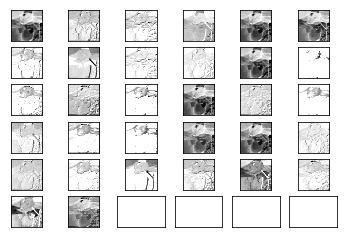

In [60]:
plot_conv_layer(layer=layer_conv1, image=image1)

The following images are the results of applying the convolutional filters to the second image.

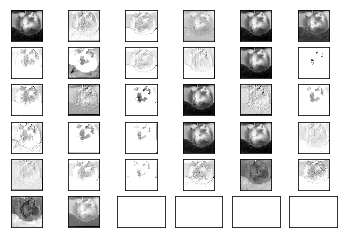

In [61]:
plot_conv_layer(layer=layer_conv1, image=image2)

### Convolution Layer 2

Now plot the filter-weights for the second convolutional layer.

There are 16 output channels from the first conv-layer, which means there are 16 input channels to the second conv-layer. The second conv-layer has a set of filter-weights for each of its input channels. We start by plotting the filter-weigths for the first channel.

Note again that positive weights are red and negative weights are blue.

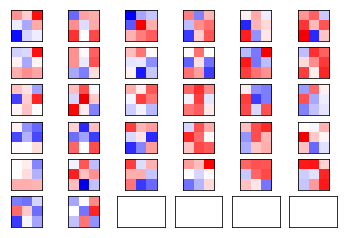

In [62]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

There are 16 input channels to the second convolutional layer, so we can make another 15 plots of filter-weights like this. We just make one more with the filter-weights for the second channel. 

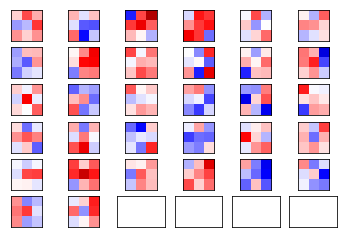

In [63]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

It can be difficult to understand and keep track of how these filters are applied because of the high dimensionality.

Applying these convolutional filters to the images that were ouput from the first conv-layer gives the following images.

Note that these are down-sampled yet again to half the resolution of the images from the first conv-layer.

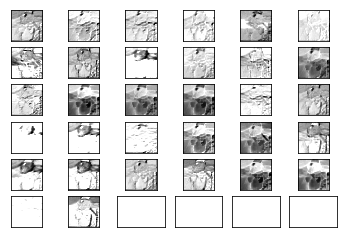

In [64]:
plot_conv_layer(layer=layer_conv2, image=image1)

And these are the results of applying the filter-weights to the second image.

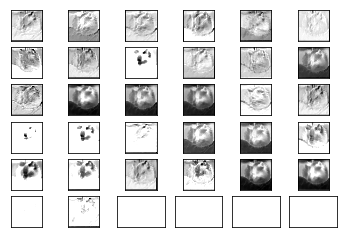

In [65]:
plot_conv_layer(layer=layer_conv2, image=image2)

### Write Test Predictions to CSV

In [66]:
# def write_predictions(ims, ids):
#     ims = ims.reshape(ims.shape[0], img_size_flat)
#     preds = session.run(y_pred, feed_dict={x: ims})
#     result = pd.DataFrame(preds, columns=classes)
#     result.loc[:, 'id'] = pd.Series(ids, index=result.index)
#     pred_file = 'predictions.csv'
#     result.to_csv(pred_file, index=False)

# write_predictions(test_images, test_ids)

### Close TensorFlow Session

We are now done using TensorFlow, so we close the session to release its resources.

In [67]:
session.close()